In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [2]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [3]:
### Data Loading
from datasets import CelebA, get_train_loader, get_test_loader

root_dir = "/mnt/d/datasets/celeba"
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
])

train_loader = get_train_loader(dataset=CelebA(root_dir, "train", transform=transform), batch_size=BATCH_SIZE)
valid_loader = get_test_loader(dataset=CelebA(root_dir, "valid", transform=transform), batch_size=32)
test_loader = get_test_loader(dataset=CelebA(root_dir, "test", transform=transform), batch_size=32)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(valid_loader))
images, labels = batch["image"], batch["label"]
print(f"\nvalid dataset: {len(valid_loader.dataset)}, dataloader: {len(valid_loader)}")
print(f"valid images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"valid labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 162770, dataloader: 1271
train images: torch.Size([128, 3, 32, 32]), torch.float32, 0.0, 1.0
train labels: torch.Size([128]), torch.int64, 0, 1

valid dataset: 19867, dataloader: 621
valid images: torch.Size([32, 3, 32, 32]), torch.float32, 0.0, 1.0
valid labels: torch.Size([32]), torch.int64, 0, 1

test dataset: 19962, dataloader: 624
test  images: torch.Size([32, 3, 32, 32]), torch.float32, 0.0, 1.0
test  labels: torch.Size([32]), torch.int64, 0, 1


In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=Z_DIM, in_channels=CHANNELS):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.flatten_size = NUM_FEATURES * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16)
        self.fc1 = nn.Linear(self.flatten_size, latent_dim)
        self.fc2 = nn.Linear(self.flatten_size, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return mu + std * eps

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, self.flatten_size)
        mu, logvar = self.fc1(x), self.fc2(x)
        latent = self.reparameterize(mu, logvar)
        return latent, mu, logvar

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=Z_DIM, out_channels=CHANNELS):
        super().__init__()

        self.flatten_size = NUM_FEATURES * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16)
        self.fc = nn.Linear(latent_dim, self.flatten_size)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2)
        )
        self.deconv5 = nn.ConvTranspose2d(NUM_FEATURES, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, NUM_FEATURES, IMAGE_SIZE // 16, IMAGE_SIZE // 16)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = torch.sigmoid(x)
        return x

In [6]:
### Modeling: Variational Autoencoder

class VAE(nn.Module):
    def __init__(self, encoder, decoder, beta=500):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        # self.bce_loss = nn.BCELoss(reduction='none')
        self.bce_loss = nn.MSELoss(reduction='none')

    def forward(self, images):
        latent, mu, logvar = self.encoder(images)
        recon = self.decoder(latent)
        return recon, latent, mu, logvar

    @property
    def device(self):
        return next(self.parameters()).device

    def loss_fn(self, recon, images, mu, logvar):
        bce_pixel = self.bce_loss(recon, images)
        bce = bce_pixel.view(bce_pixel.size(0), -1).mean(dim=1)    # (B,)
        bce = self.beta * bce.mean() 

        kld_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)  # (B,)
        kld = kld_sample.mean()

        loss =  bce + kld
        return loss, bce, kld

    def train_step(self, batch, optimizer):
        images = batch["image"].to(self.device)
        optimizer.zero_grad()
        recon, latent, mu, logvar = self.forward(images)
        loss, bce, kld = self.loss_fn(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()
        return dict(loss=loss, bce=bce, kld=kld)

    @torch.no_grad()
    def eval_step(self, batch):
        images = batch["image"].to(self.device)
        recon, latent, mu, logvar = self.forward(images)
        loss, bce, kld = self.loss_fn(recon, images, mu, logvar)
        return dict(loss=loss, bce=bce, kld=kld)

    @torch.no_grad()
    def pred_step(self, batch):
        images = batch["image"].to(self.device)
        labels = batch["label"]
        recon, latent, mu, logvar = self.forward(images)
        return dict(image=images, label=labels, latent=latent, recon=recon)

In [7]:
from trainer import fit, evaluate, predict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(latent_dim=Z_DIM, in_channels=CHANNELS).to(device)
decoder = Decoder(latent_dim=Z_DIM, out_channels=CHANNELS).to(device)
model = VAE(encoder, decoder, beta=2000).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [8]:
history = fit(model, train_loader, optimizer, num_epochs=10, valid_loader=test_loader)

[  1/10] loss:66.696, bce:51.519, kld:15.177 | (val) loss:56.171, bce:40.111, kld:16.060


[  2/10] loss:55.667, bce:39.757, kld:15.910 | (val) loss:54.333, bce:38.125, kld:16.208


[  3/10] loss:54.213, bce:37.998, kld:16.215 | (val) loss:52.926, bce:36.467, kld:16.459


[  4/10] loss:53.049, bce:36.424, kld:16.626 | (val) loss:52.139, bce:35.721, kld:16.417


[  5/10] loss:52.512, bce:35.768, kld:16.744 | (val) loss:51.896, bce:35.184, kld:16.712


[  6/10] loss:52.203, bce:35.378, kld:16.825 | (val) loss:51.908, bce:35.082, kld:16.826


[  7/10] loss:51.950, bce:35.035, kld:16.915 | (val) loss:51.469, bce:34.635, kld:16.834


[  8/10] loss:51.720, bce:34.670, kld:17.051 | (val) loss:51.244, bce:34.084, kld:17.160


[  9/10] loss:51.505, bce:34.351, kld:17.154 | (val) loss:51.074, bce:33.956, kld:17.117


[ 10/10] loss:51.342, bce:34.118, kld:17.225 | (val) loss:50.924, bce:33.623, kld:17.301


In [9]:
from utils import show_images

predictions = predict(model, test_loader)
images = predictions["image"]
labels = predictions["label"]
latent = predictions["latent"]
recon  = predictions["recon"]

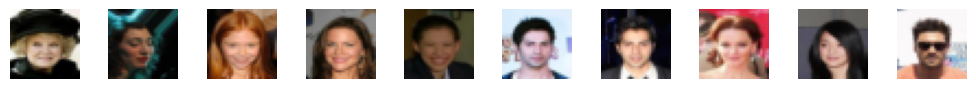

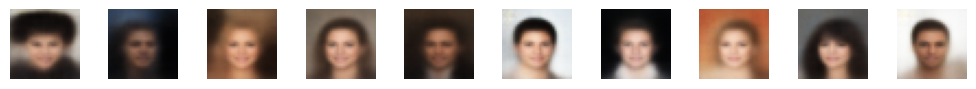

In [10]:
show_images(*images[:10], ncols=10, xunit=1, yunit=1)
show_images(*recon[:10], ncols=10, xunit=1, yunit=1)